### Example of using CMSSpark for analysis workflow

In [1]:
# IMPORTANT!!!
# ------------
# Before running this notebook please click on star icon (if it is there) to connect to Spark cluster
# it setups spark context variables used in this notebook

In [4]:
# execute this cell which downloads required libraries and put them in place
import os
with open('env.sh', 'w') as ostream:
    ostream.write("""#!/bin/bash
wdir=$PWD/wdir
if [ -d $wdir ]; then
    rm -rf $wdir
fi
mkdir -p $wdir
cd $wdir
wget https://my.pcloud.com/publink/show?code=XZwzn97ZIoG4isDNO3b6SrTEUfQ1Y4E6bp9k -O ./avro-mapred.jar
wget https://my.pcloud.com/publink/show?code=XZazn97Z9aGq81aVgBLcHi9LBNqryuqs310V -O ./spark-csv-assembly-1.4.0.jar
wget https://my.pcloud.com/publink/show?code=XZXRn97Z2I3oh9PJB2khQjedQ5woO0JTXsP7 -O ./spark-examples-1.6.0-cdh5.7.6-hadoop2.6.0-cdh5.7.6.jar
wget https://github.com/dmwm/CMSSpark/archive/master.zip -O ./master.zip
unzip ./master.zip 2> /dev/null
mv CMSSpark-master CMSSpark""")
!ls
!source ./env.sh
!ls
!cd wdir; ls

CMSSparkExample.ipynb  env.sh  setup.sh  spark-warehouse  wdir
--2018-12-07 14:08:55--  https://my.pcloud.com/publink/show?code=XZwzn97ZIoG4isDNO3b6SrTEUfQ1Y4E6bp9k
Resolving my.pcloud.com... 74.120.8.14, 74.120.9.121, 74.120.8.7, ...
Connecting to my.pcloud.com|74.120.8.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40806 (40K) [text/html]
Saving to: “./avro-mapred.jar”

100%[======================================>] 40,806      --.-K/s   in 0.1s    

2018-12-07 14:08:55 (330 KB/s) - “./avro-mapred.jar” saved [40806/40806]

--2018-12-07 14:08:55--  https://my.pcloud.com/publink/show?code=XZazn97Z9aGq81aVgBLcHi9LBNqryuqs310V
Resolving my.pcloud.com... 74.120.8.6, 74.120.9.121, 74.120.8.226, ...
Connecting to my.pcloud.com|74.120.8.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/html]
Saving to: “./spark-csv-assembly-1.4.0.jar”

100%[======================================>] 40,905      --.-K/s   in 0.1s    

2018

In [6]:
# include the CMSSpark python in the sys.path
import os,sys
sys.path.append(os.path.join(os.path.expanduser("~"), 'SWAN_projects/CMSSpark/wdir/CMSSpark/src/python'))
#print(sys.path)

In [8]:
# system modules
import os
import re
import sys
import time
import json

from pyspark import SparkContext, StorageLevel
from pyspark.sql import SQLContext

# CMSSpark modules
from CMSSpark.spark_utils import dbs_tables, phedex_tables, print_rows
from CMSSpark.spark_utils import spark_context, split_dataset
from CMSSpark.utils import info
from CMSSpark.conf import OptionParser


# define spark context, it's main object which allow to communicate with spark
yarn = False # use yarn scheduler or not
verbose = 1 # use verbose output or not
#ctx = spark_context('cms', yarn, verbose)

# use existing spark context (it is created for us on SWAN), it's main object which allow to communicate with spark
ctx = sc
sqlContext = SQLContext(ctx)

# read DBS and Phedex tables
tables = {}
inst = 'GLOBAL'
tables.update(dbs_tables(sqlContext, inst=inst, verbose=verbose, tables=['ddf', 'bdf', 'fdf']))
ddf = tables['ddf']
bdf = tables['bdf']
fdf = tables['fdf']
print(tables)

# join tables
cols = ['d_dataset','d_dataset_id', 'd_creation_date', 'b_block_id','b_file_count','f_block_id','f_file_id','f_dataset_id','f_event_count','f_file_size']

# join tables
stmt = 'SELECT %s FROM ddf JOIN bdf on ddf.d_dataset_id = bdf.b_dataset_id JOIN fdf on bdf.b_block_id=fdf.f_block_id' % ','.join(cols)
print(stmt)
joins = sqlContext.sql(stmt)

# keep table around
joins.persist(StorageLevel.MEMORY_AND_DISK)

# construct aggregation
fjoin = joins\
            .groupBy(['d_creation_date'])\
            .agg({'b_file_count':'sum', 'f_event_count':'sum', 'f_file_size':'sum'})\
            .withColumnRenamed('sum(b_file_count)', 'nfiles')\
            .withColumnRenamed('sum(f_event_count)', 'nevents')\
            .withColumnRenamed('sum(f_file_size)', 'size')\
            .withColumnRenamed('d_creation_date', 'creation_date')

Use the following data on HDFS
Lookup area: hadoop fs -ls hdfs:///project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/DATASETS | awk '{print $8}'
Lookup area: hadoop fs -ls hdfs:///project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/BLOCKS | awk '{print $8}'
Lookup area: hadoop fs -ls hdfs:///project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/FILES | awk '{print $8}'
{'bdf': DataFrame[b_block_id: int, b_block_name: string, b_dataset_id: int, b_open_for_writing: int, b_origin_site_name: string, b_block_size: double, b_file_count: int, b_creation_date: double, b_create_by: string, b_last_modification_date: double, b_last_modified_by: string], 'ddf': DataFrame[d_dataset_id: int, d_dataset: string, d_is_dataset_valid: int, d_primary_ds_id: int, d_processed_ds_id: int, d_data_tier_id: int, d_dataset_access_type_id: int, d_acquisition_era_id: int, d_processing_era_id: int, d_physics_group_id: int, d_xtcrosssection: double, d_prep_id: string, d_creation_date: double, d_create_by: string, d_last_modification_date

In [9]:
# let's inspect our data
fjoin.show(10)

+-------------+------------------+------+---------+
|creation_date|              size|nfiles|  nevents|
+-------------+------------------+------+---------+
| 1.19608534E9|     6.11455155E10|  1407|  1635998|
|1.246331625E9|  4.30966777601E11| 18900|  2863211|
|1.269091189E9|   1.7983180904E10| 18242|   102629|
|1.271722695E9|  2.71054273069E11|   859|400001639|
|1.274297294E9|     1.673262019E9| 10051|   281354|
|1.277132953E9|1.0322970571177E13|577569| 10161297|
|1.288977051E9|  7.96258973903E11|   902|  5433269|
|1.289509213E9|     7.519344113E9|   698|   374670|
|1.298014455E9| 5.158381106551E12|  4868|  1883200|
|1.299105033E9|      3.57580188E9|     0|    18000|
+-------------+------------------+------+---------+
only showing top 10 rows



In [10]:
# let's collect our results into pandas dataframe and use it further for analysis
pdf = fjoin.toPandas()
pdf.head()
# here you can add additional analysis

,creation_date,size,nfiles,nevents
0,1.196085e+09,6.114552e+10,1407,1635998
1,1.249055e+09,5.696446e+11,25276,1014413
2,1.268666e+09,5.780090e+09,0,9000
3,1.269091e+09,1.798318e+10,18242,102629
4,1.274297e+09,1.673262e+09,10051,281354


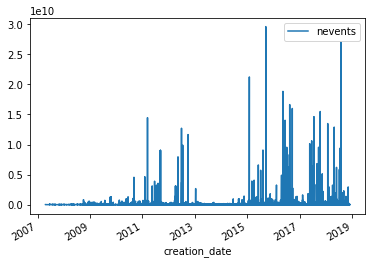

In [38]:
# adjust creation_date to be treated as dates
import pandas as pd
from datetime import datetime
pdf['creation_date'] = pd.to_datetime(pdf.creation_date)

# plot total number of events we got as a time series
# for pandas visualization please see: https://pandas.pydata.org/pandas-docs/stable/visualization.html
import matplotlib.pyplot as plt
pdf.plot(x='creation_date', y='nevents')
plt.show()

In [39]:
# save plot into PDF file
plt.savefig('plot.pdf')

<Figure size 432x288 with 0 Axes>